# Run a trained model on images and show results

In [1]:
import sys
sys.path.append("../src")

In [2]:
import os
import json

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm

from slim_models.nets import resnet_v1, inception_resnet_v2, nasnet
from input_utils import preprocess_image_for_visualization, normalize_image, preprocess_image
from models import model_fn
from tools.utils import ImageDecoder

%matplotlib inline

/home/ubuntu/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
class_id_filepath = "/home/ubuntu/Data/dataset/recycle/data/interim/non_dup_v1/class.json"
with open(class_id_filepath, "rt") as f:
    name_to_class_id = json.loads(f.read())

id_to_class_name = {v: k for k, v in name_to_class_id.items()}

In [4]:
val_metadata_filepath = "/home/ubuntu/Data/dataset/recycle/data/interim/non_dup_v1/recycle-val_metadata.json"
with open(val_metadata_filepath, "rt") as f:
    val_metadata = json.loads(f.read())
    
samples_per_class = val_metadata["samples_per_class"]

In [5]:
def input_fn(filepaths, visualize=False, network_name="resnet_v1_101"):
    dataset = tf.data.Dataset.from_tensor_slices(filepaths)
    
    def read_file(filepath):
        image_str = tf.read_file(filepath)
        image_decoded = tf.image.decode_image(image_str, channels=3)
        return image_decoded
    
    def preprocess(image):
        if visualize:
            image = preprocess_image_for_visualization(image, network_name)
        else:
            image = preprocess_image(image, network_name, is_training=False)
            
        image = tf.expand_dims(image, 0)
        return image
        
    dataset = dataset.map(read_file)
    dataset = dataset.map(preprocess)
    iterator = dataset.make_one_shot_iterator()
    features = {
        "image": iterator.get_next()
    }
    labels = tf.constant(1)
    return features, labels

In [6]:
model_dir = "../logs/SIGM00/"
params = {
    "num_classes": 30,
    "network_name": "nasnet_large",
    "output_type": "sigmoid"
}
estimator = tf.estimator.Estimator(model_fn, model_dir=model_dir, params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../logs/SIGM00/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc030534d30>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [11]:
predict_filepaths = [
#     "/home/ubuntu/github/ai/recycle/data/raw/merged_v2/split/val/re_05_Bottle/empty_plastic_bottles_000186.jpg",
#     "/home/ubuntu/Downloads/20171204_155411.jpg",
#     "/home/ubuntu/Downloads/20171204_161156.jpg",
#     "/home/ubuntu/Downloads/20171204_161457.jpg",
#     "/home/ubuntu/Downloads/20171204_161643.jpg",
    "/home/ubuntu/Pictures/recycle/test_images/24.jpg"
]

predict_filepaths = "/home/ubuntu/Dropbox/Work/images"
predict_filepaths = "/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/ChaiBinh"

In [12]:
if isinstance(predict_filepaths, str):
    folder = predict_filepaths
    predict_filepaths = []
    for dirpath, dirnames, filenames in os.walk(folder):
        for filename in filenames:
            predict_filepaths.append(os.path.join(dirpath, filename))
            
    predict_filepaths = sorted(predict_filepaths)
predict_filepaths

['/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/ChaiBinh/20171222152745112.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/ChaiBinh/20171222152747725.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/ChaiBinh/20171222152748762.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/ChaiBinh/20171222152751058.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/ChaiBinh/20171222152753788.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/ChaiBinh/20171222152756469.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/ChaiBinh/20171222152759412.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/ChaiBinh/20171222152803961.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/ChaiBinh/20171222152806653.jpg',
 

In [13]:
exp_predictions = []
for i, pred in enumerate(estimator.predict(
        input_fn=lambda: input_fn(predict_filepaths, network_name=params["network_name"]))):
    class_id = pred['class_id'][0]
    prob = pred['probs'][0]
    exp_predictions.append((id_to_class_name[class_id], str(prob[class_id])))


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:A GPU is available on the machine, consider using NCHW data format for increased speed on GPU.
INFO:tensorflow:Restoring parameters from ../logs/SIGM00/model.ckpt-16344


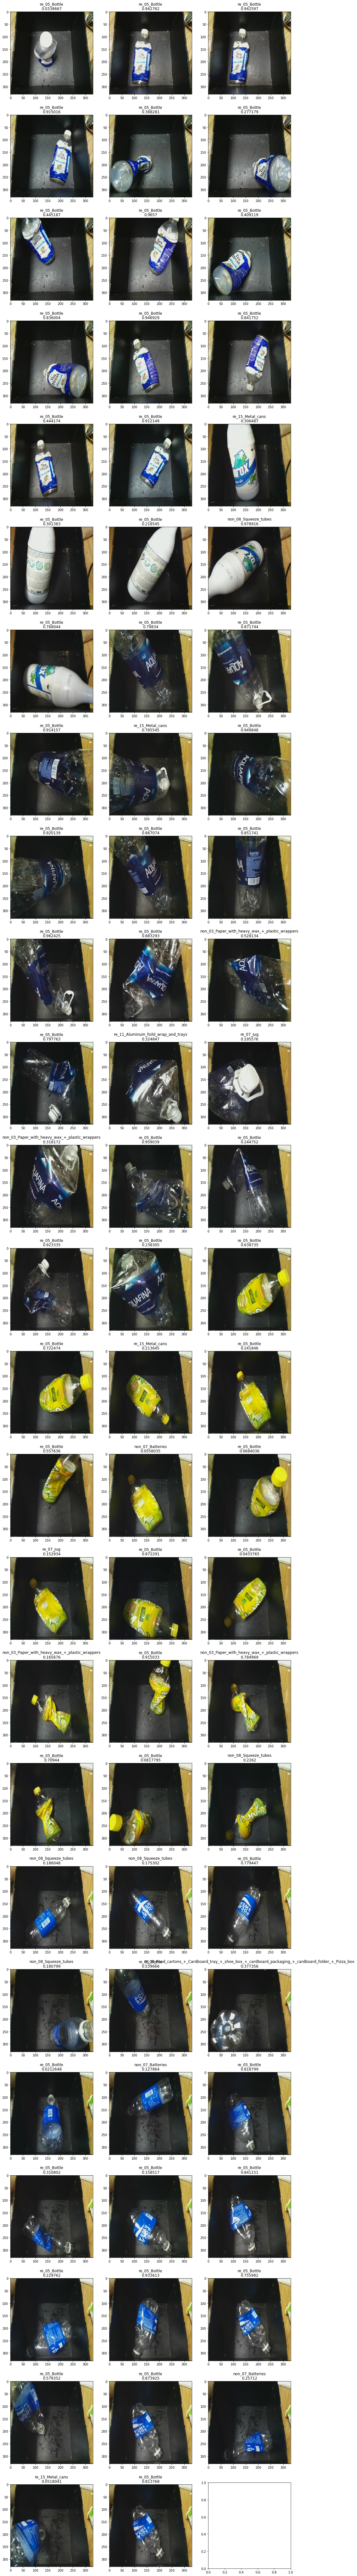

In [14]:
ncols = 3
nrows = len(predict_filepaths) // ncols + 1
fig, axs = plt.subplots(nrows, ncols,
                        figsize=(16, 6 * nrows), squeeze=False)

f, l = input_fn(predict_filepaths, visualize=True, network_name=params["network_name"])
with tf.Session() as sess:
    try:
        for i, filepath in enumerate(predict_filepaths):
            a, b = sess.run([f, l])
            img = a["image"][0].astype(np.uint8)
            axs[i // ncols][i % ncols].imshow(img)
            axs[i // ncols][i % ncols].set_title(
                exp_predictions[i][0] + "\n" + str(exp_predictions[i][1]))
    except Exception as e:
        print(e)


# Confusion matrix of trained model on validation data

In [20]:
def input_fn_from_tfrecords(file_patterns, batch_size, visualize=False, network_name="resnet_v1_101"):
    """Input function for Resnet Estimator."""
    filenames = []
    for pattern in file_patterns.split(","):
        filenames.extend(tf.gfile.Glob(pattern))

    def parser(record):
        """Parse tf.Example protobuf."""
        keys_to_features = {
            "image/data": tf.FixedLenFeature((), tf.string),
            "label": tf.FixedLenFeature((), tf.int64)
        }
        parsed = tf.parse_single_example(record, features=keys_to_features)

        image = tf.image.decode_image(parsed["image/data"], channels=3)
        label = parsed["label"]

        return image, label
    
    def preprocess(image, label):
        if visualize:
            image = preprocess_image_for_visualization(image, network_name)
        else:
            image = preprocess_image(image, network_name, is_training=False)
            
        label = tf.to_int32(label)
        return {"image": image}, label

    with tf.device('/cpu:0'):
        # Create the dataset
        dataset = tf.data.TFRecordDataset(filenames, buffer_size=256 * 2 ** 20)
        dataset = dataset.map(parser, num_parallel_calls=batch_size * 10)
        dataset = dataset.map(preprocess,
                              num_parallel_calls=batch_size * 10)
        dataset = dataset.batch(batch_size=batch_size)
        dataset = dataset.prefetch(batch_size)

        # Create iterator for the dataset
        iterator = dataset.make_one_shot_iterator()
        features, labels = iterator.get_next()

    return features, labels

In [18]:
model_dir = "../logs/DROPOUT00/"
params = {
    "num_classes": 30,
    "network_name": "nasnet_large"
}
estimator = tf.estimator.Estimator(model_fn, model_dir=model_dir, params=params)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '../logs/DROPOUT00/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2511b25fd0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '../logs/DROPOUT00/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2511b25fd0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [21]:
batch_size = 64
file_patterns = "/home/ubuntu/Data/dataset/recycle/data/interim/non_dup_v1/recycle-val-*"
predictions = None
probs = None
for i, pred in enumerate(estimator.predict(
        input_fn=lambda: input_fn_from_tfrecords(file_patterns, batch_size, 
                                                 network_name=params["network_name"]))):
    class_ids = pred['class_id']
    p = pred["probs"][np.arange(len(class_ids)), class_ids]
    if predictions is None:
        predictions = class_ids
        probs = p
    else:
        predictions = np.hstack((predictions, class_ids))
        probs = np.hstack((probs, p))

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:A GPU is available on the machine, consider using NCHW data format for increased speed on GPU.


INFO:tensorflow:A GPU is available on the machine, consider using NCHW data format for increased speed on GPU.


INFO:tensorflow:Restoring parameters from ../logs/SIGM00/model.ckpt-16344


INFO:tensorflow:Restoring parameters from ../logs/SIGM00/model.ckpt-16344


In [22]:
f, l = input_fn_from_tfrecords(file_patterns, batch_size, visualize=True)
images = None
labels = None
with tf.Session() as sess:
    try:
        while True:
            a, b = sess.run([f, l])
            if labels is None:
                labels = b
                images = a["image"]
            else:
                labels = np.hstack((labels, b))
                images = np.concatenate((images, a["image"]))
    except Exception as e:
        pass
    
images = images.astype(np.uint8)
print("Accuracy on validation set:", np.mean(predictions == labels))

Accuracy on validation set: 0.79359430605


Text(184.92,0.5,'Label')

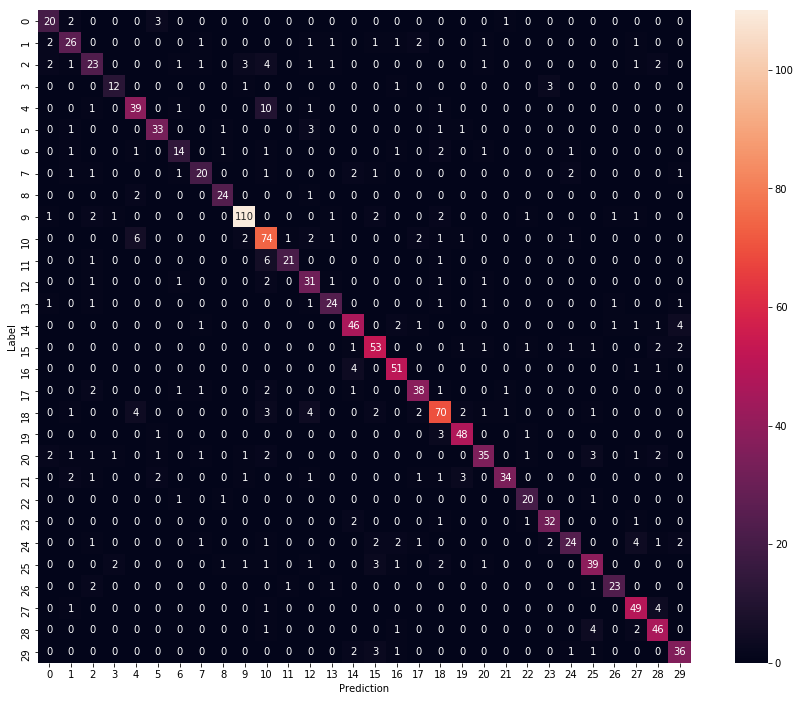

In [23]:
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt="d", square=True)
plt.xlabel("Prediction")
plt.ylabel("Label")

# Binary accuracy for recycle/non-recycle classes

In [24]:
binary_labels = labels > 9
binary_predictions = predictions > 9

In [25]:
print("Binary accuracy:", np.mean(np.equal(binary_labels, 
                                           binary_predictions).astype(np.float32)))

Binary accuracy: 0.920996


# Per-class accuracy

In [30]:
row_sum = np.sum(cm, axis=1)
per_class_acc = np.diag(cm) / row_sum
print("Mean per-class accuracy:", np.mean(per_class_acc))

Mean per-class accuracy: 0.77945464826


In [31]:
sorted_idxs = [t[0] for t in sorted(enumerate(per_class_acc), key=lambda x: x[1])]
for idx in sorted_idxs:
    print("{:2d} {:41}: {:.6f} {:3d}".format(idx, id_to_class_name[idx][:40], 
                                       per_class_acc[idx], samples_per_class[idx]))

 2 non_03_Paper_with_heavy_wax_+_plastic_wr : 0.560976  41
24 re_15_Metal_cans                         : 0.585366  41
 6 non_07_Batteries                         : 0.608696  23
 7 non_08_Squeeze_tubes                     : 0.666667  30
20 re_11_Aluminum_foild_wrap_and_trays      : 0.673077  52
 1 non_02_Pouches                           : 0.702703  37
 3 non_04_Styrofoam_containers              : 0.705882  17
11 re_02_Newspaper                          : 0.724138  29
 4 non_05_Hardcover_books                   : 0.735849  53
21 re_12_Paper_bag                          : 0.739130  46
25 re_16_Acelate_boxes_+_clamshell_containe : 0.750000  52
 0 non_01_Plastic_bags                      : 0.769231  26
18 re_09_Food_cartons_+_Cardboard_tray_+_sh : 0.769231  91
13 re_04_Wrapping_paper                     : 0.774194  31
14 re_05_Bottle                             : 0.807018  57
17 re_08_Drink_boxes_+_Beverage_cartons_+_A : 0.808511  47
10 re_01_Soft-cover_book_+_Magazine_+_Catal : 0.813187  

Text(0,0.5,'Accuracy')

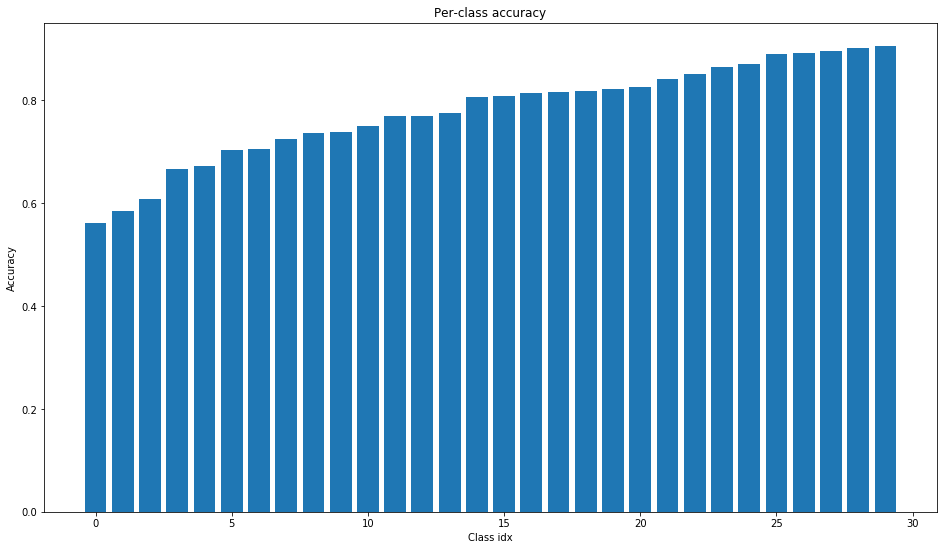

In [28]:
plt.figure(figsize=(16, 9))
plt.bar(range(len(per_class_acc)), sorted(per_class_acc))
plt.title("Per-class accuracy")
plt.xlabel("Class idx")
plt.ylabel("Accuracy")

Text(184.92,0.5,'Label')

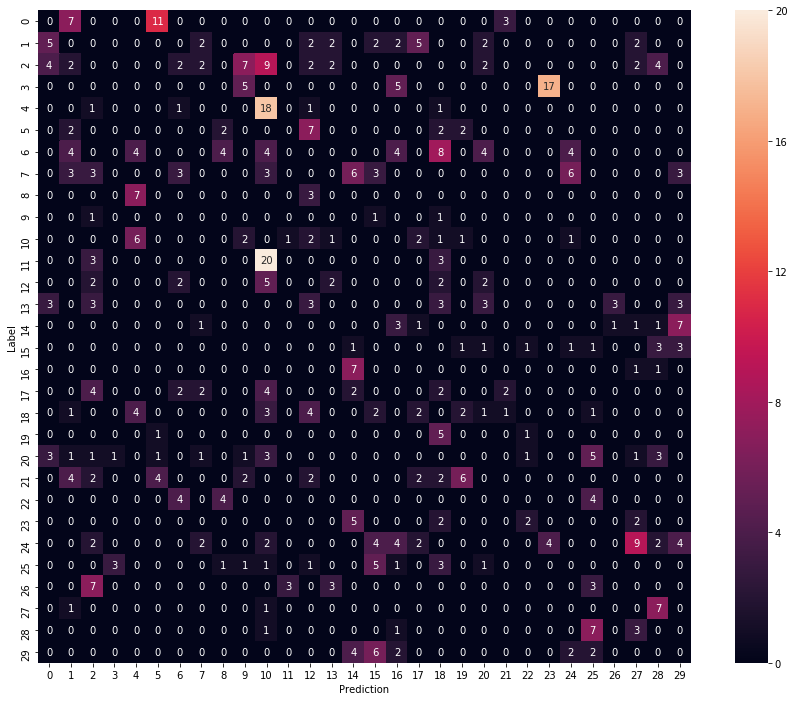

In [32]:
wrong_percentage = cm / row_sum.reshape((-1, 1))
np.fill_diagonal(wrong_percentage, 0)
plt.figure(figsize=(16, 12))
sns.heatmap((100 * wrong_percentage).astype(np.int32), annot=True, fmt="d", square=True)
plt.xlabel("Prediction")
plt.ylabel("Label")

In [49]:
id_to_class_name[3], id_to_class_name[13]

('non_04_Styrofoam_containers', 're_04_Wrapping_paper')

# Examples of wrong predictions

In [33]:
def wrong_predictions(predictions, labels, probs, filter_labels=None):
    idxs = np.argsort(probs)[::-1]
    for idx in idxs:
        if labels[idx] != predictions[idx] and \
            (filter_labels is None or labels[idx] == filter_labels):
            yield idx

In [40]:
wrong_idxs = list(wrong_predictions(predictions, labels, probs, filter_labels=6))

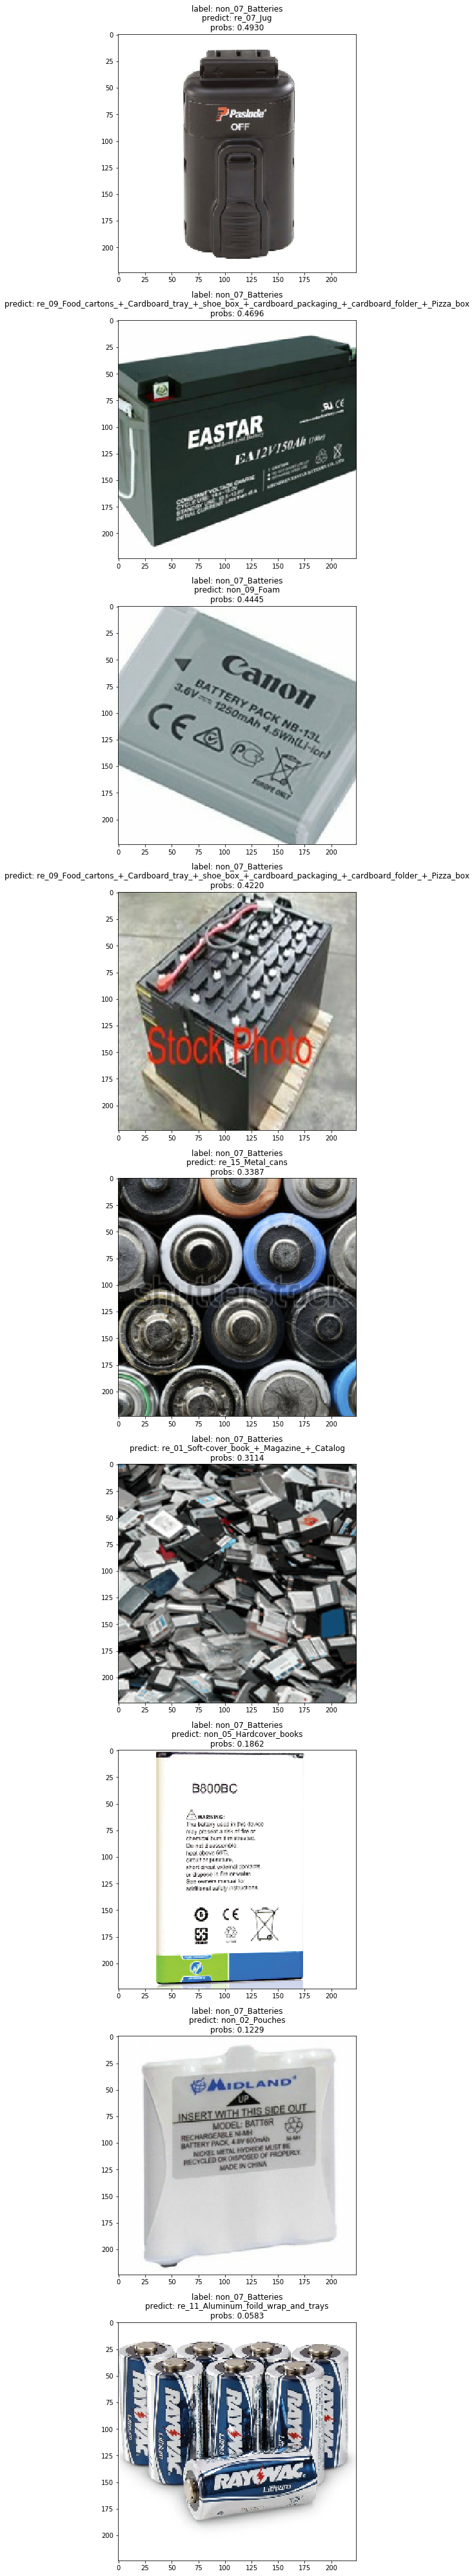

In [41]:
num_images = min(len(wrong_idxs), 20)
fig, axs = plt.subplots(num_images, figsize=(10, 8 * num_images))
for i, idx in enumerate(wrong_idxs[:num_images]):
    axs[i].imshow(images[idx])
    axs[i].set_title("label: {}\npredict: {}\nprobs: {:.4f}".format(
        id_to_class_name[labels[idx]], id_to_class_name[predictions[idx]], probs[idx]))

# ROC

In [42]:
binary_labels = labels > 9
binary_predictions = predictions > 9
conf = probs.copy()
conf[binary_predictions == 0] = 1 - conf[binary_predictions == 0]
idxs = np.argsort(conf)[::-1]

tp = 0
fp = 0
fn = np.sum(binary_labels == 1)
tn = np.sum(binary_labels == 0)
tpr, fpr, acc = [], [], []

for k, i in enumerate(idxs):
    if binary_labels[i]:
        tp += 1
        fn -= 1
    else:
        fp += 1
        tn -= 1
    tpr.append(tp / (tp + fn))
    fpr.append(fp / (fp + tn))
    acc.append((tp + tn) / (tp + tn + fp + fn))
    print(conf[i], tpr[-1], fpr[-1], acc[-1])
        

1.0 0.0010111223458 0.0 0.296797153025
0.999987 0.00202224469161 0.0 0.297508896797
0.999981 0.00303336703741 0.0 0.298220640569
0.999976 0.00404448938322 0.0 0.298932384342
0.999937 0.00505561172902 0.0 0.299644128114
0.999923 0.00606673407482 0.0 0.300355871886
0.999901 0.00707785642063 0.0 0.301067615658
0.999881 0.00808897876643 0.0 0.301779359431
0.999831 0.00910010111223 0.0 0.302491103203
0.999793 0.010111223458 0.0 0.303202846975
0.999664 0.0111223458038 0.0 0.303914590747
0.999628 0.0121334681496 0.0 0.30462633452
0.999626 0.0131445904954 0.0 0.305338078292
0.999615 0.0141557128413 0.0 0.306049822064
0.999556 0.0151668351871 0.0 0.306761565836
0.999531 0.0161779575329 0.0 0.307473309609
0.999471 0.0171890798787 0.0 0.308185053381
0.999459 0.0182002022245 0.0 0.308896797153
0.99938 0.0192113245703 0.0 0.309608540925
0.999304 0.0202224469161 0.0 0.310320284698
0.999286 0.0212335692619 0.0 0.31103202847
0.999244 0.0222446916077 0.0 0.311743772242
0.999214 0.0232558139535 0.0 0.31

0.73048 0.621840242669 0.0913461538462 0.706761565836
0.729419 0.622851365015 0.0913461538462 0.707473309609
0.729275 0.623862487361 0.0913461538462 0.708185053381
0.728315 0.624873609707 0.0913461538462 0.708896797153
0.72721 0.624873609707 0.09375 0.708185053381
0.72657 0.625884732053 0.09375 0.708896797153
0.725292 0.626895854398 0.09375 0.709608540925
0.725191 0.627906976744 0.09375 0.710320284698
0.724702 0.62891809909 0.09375 0.71103202847
0.724296 0.62891809909 0.0961538461538 0.710320284698
0.723976 0.62891809909 0.0985576923077 0.709608540925
0.723445 0.629929221436 0.0985576923077 0.710320284698
0.720471 0.630940343782 0.0985576923077 0.71103202847
0.720285 0.631951466127 0.0985576923077 0.711743772242
0.718421 0.632962588473 0.0985576923077 0.712455516014
0.717807 0.632962588473 0.100961538462 0.711743772242
0.71752 0.632962588473 0.103365384615 0.71103202847
0.716866 0.633973710819 0.103365384615 0.711743772242
0.713059 0.634984833165 0.103365384615 0.712455516014
0.712786 

0.0262589 0.996966632963 0.75 0.775800711744
0.0261943 0.996966632963 0.752403846154 0.775088967972
0.0261092 0.996966632963 0.754807692308 0.774377224199
0.0260593 0.996966632963 0.757211538462 0.773665480427
0.025964 0.996966632963 0.759615384615 0.772953736655
0.0258282 0.996966632963 0.762019230769 0.772241992883
0.025152 0.996966632963 0.764423076923 0.77153024911
0.024835 0.997977755308 0.764423076923 0.772241992883
0.0247507 0.997977755308 0.766826923077 0.77153024911
0.0242403 0.997977755308 0.769230769231 0.770818505338
0.0238203 0.998988877654 0.769230769231 0.77153024911
0.0236859 0.998988877654 0.771634615385 0.770818505338
0.0234137 0.998988877654 0.774038461538 0.770106761566
0.0222977 0.998988877654 0.776442307692 0.769395017794
0.0221802 0.998988877654 0.778846153846 0.768683274021
0.0218953 0.998988877654 0.78125 0.767971530249
0.0216729 0.998988877654 0.783653846154 0.767259786477
0.0216518 0.998988877654 0.786057692308 0.766548042705
0.0208598 0.998988877654 0.788461

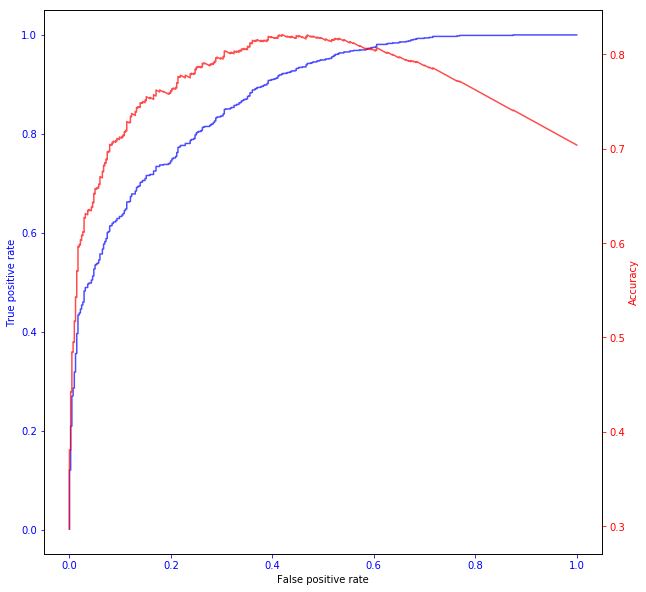

In [43]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.plot(fpr, tpr, 'b-', alpha=0.7)
ax1.set_xlabel("False positive rate")
ax1.set_ylabel("True positive rate", color='b')
ax1.tick_params(colors='b')

ax2 = ax1.twinx()
ax2.plot(fpr, acc, 'r-', alpha=0.7)
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(colors='r')